This notebook represents the implementation of different optimisation algorithms such as Momentum, AdaGrad, RMSprop etc. for the gradient descent.

The example is used from the course (CS231n Stanford) where a simple neural network in 2 dimensions is implemented.<br/>
http://cs231n.github.io/neural-networks-case-study/

To read further about the topics please refer to the following links;<br/>
http://cs231n.github.io/neural-networks-3/<br/>
http://sebastianruder.com/optimizing-gradient-descent/index.html#fnref:1


In [73]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generating and Plotting Data to work with 

(-1, 1)

/Applications/anaconda/anaconda2/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


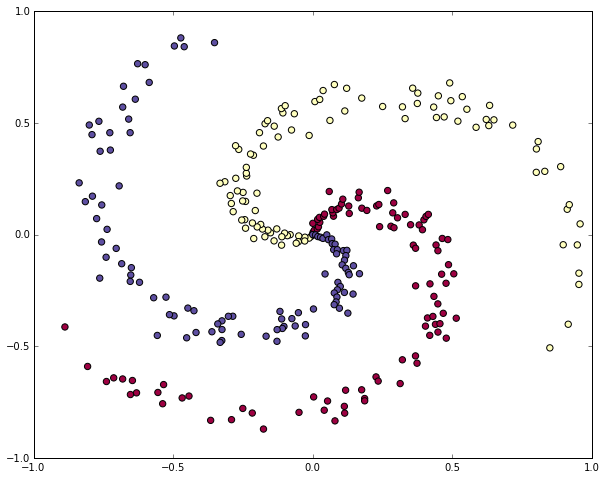

In [2]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

#### Vanilla SGD Update 

\begin{equation*}
W +=  - (LearningRate)*dW
\end{equation*}

#### 2 layer NN 

In [88]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h)) ## bias term
W2 = 0.01 * np.random.randn(h,K) ## weights for the second layer
b2 = np.zeros((1,K)) ## bias term for second layer

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]

loss_history_vanilla = []
iterations = []
for i in xrange(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  
  if i % 10 == 0:
    #print "iteration %d: loss %f" % (i, loss)
    loss_history_vanilla.append(loss)
    iterations.append(i)
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2



##### Momentum Update



\begin{equation*}
v = mu*v - (LearningRate)*dW 
\end{equation*}
\begin{equation*}
W  += v
\end{equation*}

In [90]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h)) ## bias term
W2 = 0.01 * np.random.randn(h,K) ## weights for the second layer
b2 = np.zeros((1,K)) ## bias term for second layer

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength
mu = 0.9 # mu parameter for the Momentum Update
v = 0 * np.random.randn(D,h)
v2 = 0 * np.random.randn(h,K) 
# gradient descent loop
num_examples = X.shape[0]

loss_history_momentum = []
iterations = []
for i in xrange(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  
  if i % 10 == 0:
    #print "iteration %d: loss %f" % (i, loss)
    loss_history_momentum.append(loss)
    iterations.append(i)
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update (Momentum with mu = 0.9)
  v = mu * v - step_size*dW
  W += v
  b += -step_size * db
  
  v2 = mu * v2 - step_size*dW2
  W2 += v2
  b2 += -step_size * db2



##### Nestrov Momentum Update

In [91]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h)) ## bias term
W2 = 0.01 * np.random.randn(h,K) ## weights for the second layer
b2 = np.zeros((1,K)) ## bias term for second layer

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength
mu = 0.9 # mu parameter for the Momentum Update
v_prev = np.zeros((D,h))
v2_prev = np.zeros((h,K))
v = np.zeros((D,h))
v2 = np.zeros((h,K))
# gradient descent loop
num_examples = X.shape[0]

loss_history_Nmomentum = []
iterations = []
for i in xrange(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  
  if i % 10 == 0:
    #print "iteration %d: loss %f" % (i, loss)
    loss_history_Nmomentum.append(loss)
    iterations.append(i)
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update (Momentum with mu = 0.9)
  v_prev = v
  v = mu * v - step_size*dW
  W += -mu*v_prev + (1+mu)*v
  b += -step_size * db
  
  v2_prev = v2
  v2 = mu * v2 - step_size*dW2
  W2 += -mu*v2_prev + (1+mu)*v2
  b2 += -step_size * db2


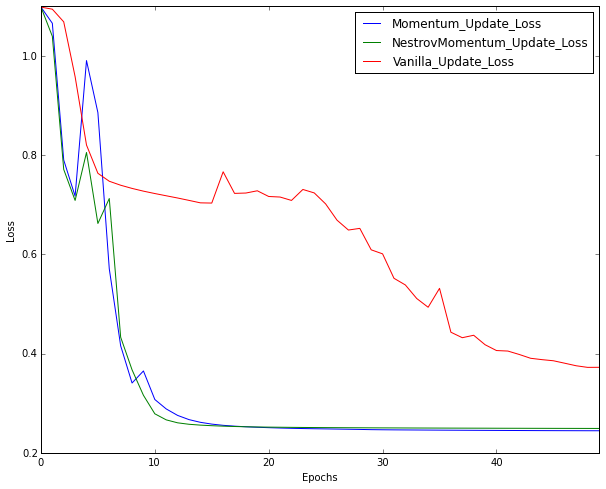

In [97]:
losses = {}
losses = {'Vanilla_Update_Loss':loss_history_vanilla,'Momentum_Update_Loss':loss_history_momentum,'NestrovMomentum_Update_Loss':loss_history_Nmomentum}
df = pd.DataFrame.from_dict(losses)

ax = df[0:50].plot()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

##### Evaluating the Effeciency of the Network

In [98]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.98


##### Plotting the data with the NN for better visualization


(-1.8712034092398278, 1.8687965907601756)

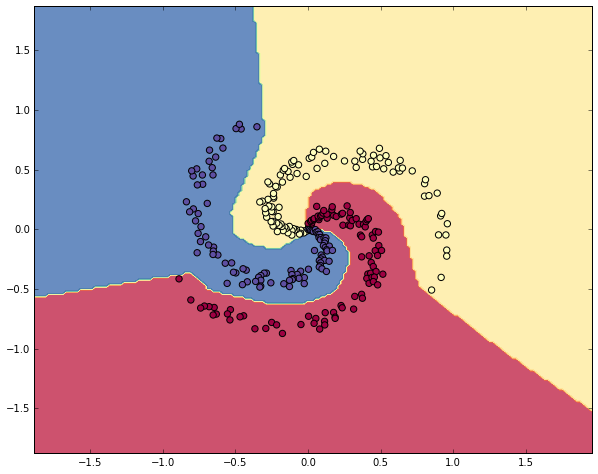

In [99]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
